In [104]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np
import os
import pandas as pd

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [105]:
# Define label mapping for classes
label_map = {
    "tetragonal": 0,
    "orthorhombic": 1,
    "trigonal": 2,
    "cubic": 3,
    "triclinic": 4,
    "monoclinic": 5,
    "hexagonal": 6
}

# Label names
label_names = [
    "tetragonal", "orthorhombic", "trigonal", 
    "cubic", "triclinic", "monoclinic", "hexagonal"
]

csv_path = "/Users/wasslu/Desktop/NTU/MLPhys/ML-course/testdata/structure_info.csv"
data_dir = "/Users/wasslu/Desktop/NTU/MLPhys/ML-course/output_data"
df = pd.read_csv(csv_path)

In [108]:
from scipy.signal import find_peaks
from scipy.signal import peak_widths

# Function to extract features from XRD data
def extract_features_with_all_peaks(intensity, angles, max_peaks=10):
    # Find all peaks
    peaks, _ = find_peaks(intensity, height=0.05 * np.max(intensity))  # Adjust height threshold
    peak_positions = angles[peaks]  # Positions of detected peaks (2θ values)
    peak_intensities = intensity[peaks]  # Intensities of detected peaks

    # Total number of detected peaks
    num_detected_peaks = len(peaks)

    # If fewer peaks are detected than the maximum allowed, pad with zeros
    if num_detected_peaks < max_peaks:
        peak_positions = np.pad(peak_positions, (0, max_peaks - num_detected_peaks), mode='constant')
        peak_intensities = np.pad(peak_intensities, (0, max_peaks - num_detected_peaks), mode='constant')
        widths = np.zeros(max_peaks)
    else:
        # Compute Full Width at Half Maximum (FWHM) of each peak
        widths = peak_widths(intensity, peaks)[0]  # widths of the peaks

    # Compute global statistics
    avg_peak_intensity = np.mean(peak_intensities) if num_detected_peaks > 0 else 0
    std_peak_intensity = np.std(peak_intensities) if num_detected_peaks > 0 else 0
    mean_fwhm = np.mean(widths) if num_detected_peaks > 0 else 0
    std_fwhm = np.std(widths) if num_detected_peaks > 0 else 0

    # Create feature vector with peak positions, intensities, and FWHM, followed by global statistics
    feature_vector = np.concatenate([
        peak_positions[:max_peaks],  # First 10 peaks' positions
        peak_intensities[:max_peaks],  # First 10 peaks' intensities
        #widths[:max_peaks],  # First 10 peaks' FWHM values
        #[num_detected_peaks, avg_peak_intensity, std_peak_intensity]
        [num_detected_peaks]
    ])

    return feature_vector

def process_data_with_all_peaks(file_list, data_dir, max_peaks=10):
    features = []
    labels = []
    for file_name, label in file_list:
        # Replace .cif with .npz
        file_name = file_name.replace('.cif', '_convolved.npz')
        file_path = os.path.join(data_dir, file_name)
        data = np.load(file_path)
        intensity = data['y_convolved'].astype(np.float32)
        angles = data['x_fine'].astype(np.float32)

        # Extract features with all peaks and statistics
        feature = extract_features_with_all_peaks(intensity, angles, max_peaks)
        features.append(feature)
        labels.append(label_map[label])

    return np.array(features), np.array(labels)

In [109]:
def extract_features_with_sorted_peaks(intensity, angles, max_peaks=10):
    # Find all peaks
    peaks, properties = find_peaks(intensity, height=0.05 * np.max(intensity))  # Adjust height threshold
    peak_positions = angles[peaks]  # Positions of detected peaks (2θ values)
    peak_intensities = intensity[peaks]  # Intensities of detected peaks

    # Sort peaks by intensity in descending order
    sorted_indices = np.argsort(peak_intensities)[::-1]
    sorted_peak_positions = peak_positions[sorted_indices]
    sorted_peak_intensities = peak_intensities[sorted_indices]

    # Total number of detected peaks
    num_detected_peaks = len(peaks)

    # If fewer peaks are detected than the maximum allowed, pad with zeros
    if num_detected_peaks < max_peaks:
        sorted_peak_positions = np.pad(sorted_peak_positions, (0, max_peaks - num_detected_peaks), mode='constant')
        sorted_peak_intensities = np.pad(sorted_peak_intensities, (0, max_peaks - num_detected_peaks), mode='constant')
    else:
        # Limit to the top `max_peaks`
        sorted_peak_positions = sorted_peak_positions[:max_peaks]
        sorted_peak_intensities = sorted_peak_intensities[:max_peaks]

    # Create feature vector with sorted peak positions and intensities
    feature_vector = np.concatenate([
        sorted_peak_positions,  # Sorted peak positions
        sorted_peak_intensities  # Sorted peak intensities
    ,[num_detected_peaks]])

    return feature_vector


def process_data_with_sorted_peaks(file_list, data_dir, max_peaks=10):
    features = []
    labels = []
    for file_name, label in file_list:
        # Replace .cif with .npz
        file_name = file_name.replace('.cif', '_convolved.npz')
        file_path = os.path.join(data_dir, file_name)
        data = np.load(file_path)
        intensity = data['y_convolved'].astype(np.float32)
        angles = data['x_fine'].astype(np.float32)

        # Extract features with sorted peaks
        feature = extract_features_with_sorted_peaks(intensity, angles, max_peaks)
        features.append(feature)
        labels.append(label_map[label])

    return np.array(features), np.array(labels)


In [164]:
# Split data based on split_info
split_info = {
    "tetragonal": (3000, 500, 100),
    "orthorhombic": (3000, 500, 300),
    "trigonal": (1500, 500, 100),
    "cubic": (2000, 500, 100),
    "triclinic": (1800, 500, 100),
    "monoclinic": (3000, 500, 300),
    "hexagonal": (100, 10, 5)
}

train_list, test_list, val_list = [], [], []
for label, (train_size, test_size, val_size) in split_info.items():
    files = df[df['cell_structure'] == label][['filename', 'cell_structure']].values.tolist()

    # Split the dataset
    train_files, temp_files = train_test_split(files, train_size=train_size, random_state=42)
    test_files, temp_files = train_test_split(temp_files, train_size=test_size, random_state=42)
    val_files, temp_files = train_test_split(temp_files, train_size=val_size, random_state=42)

    train_list.extend(train_files)
    test_list.extend(test_files)
    val_list.extend(val_files)


In [146]:
# Define maximum number of peaks for padding
max_peaks = 10

# Process datasets to extract features and labels
X_train, y_train = process_data_with_all_peaks(train_list, data_dir, max_peaks)
X_test, y_test = process_data_with_all_peaks(test_list, data_dir, max_peaks)
X_val, y_val = process_data_with_all_peaks(val_list, data_dir, max_peaks)

print(X_train[0])

[17.36145401 23.96223068 24.65231133 27.63266182 29.74291039 33.10330582
 35.14354706 38.30391693 41.71432114 42.98447037  0.05396441  1.03090763
  0.68766594  0.05283605  0.26896563  0.39668053  0.68429852  0.05672311
  0.21172881  0.58514643 31.        ]


In [147]:
class XRDDataset(Dataset):
    """Custom Dataset for XRD Pattern Classification"""
    def __init__(self, features, labels):
        """
        Args:
            features (numpy array): Input XRD pattern features
            labels (numpy array): Corresponding labels
        """
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class PositionalEncoding(nn.Module):
    """Positional Encoding for Transformer"""
    def __init__(self, d_model, max_len=100):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:x.size(1), :]

In [148]:
class XRDTransformer(nn.Module):
    """Transformer Model for XRD Pattern Classification"""
    def __init__(self, input_dim, d_model, nhead, num_layers, num_classes):
        """
        Args:
            input_dim (int): Dimension of input XRD pattern features
            d_model (int): Transformer model dimension
            nhead (int): Number of attention heads
            num_layers (int): Number of transformer layers
            num_classes (int): Number of classification classes
        """
        super().__init__()
        
        # Input projection to model dimension
        self.input_projection = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.ReLU()
        )
        
        # Positional Encoding
        self.positional_encoding = PositionalEncoding(d_model)
        
        # Transformer Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=d_model * 4,
            dropout=0.1,
            activation='relu'
        )
        
        # Full Transformer Encoder
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=num_layers
        )
        
        # Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(d_model // 2, num_classes)
        )
    
    def forward(self, x):
        # x shape: [batch_size, sequence_length, input_dim]
        
        # Project input to model dimension
        x = self.input_projection(x.unsqueeze(1)).squeeze(1)
        
        # Add positional encoding
        x = self.positional_encoding(x.unsqueeze(0)).squeeze(0)
        
        # Transformer encoding
        x = self.transformer_encoder(x.unsqueeze(0)).squeeze(0)
        
        # Classify
        return self.classifier(x)

In [149]:
def train_xrd_classifier(model, train_loader, val_loader, criterion, optimizer, 
                          device, num_epochs=50, patience=10):
    """
    Training function for XRD Transformer with early stopping
    
    Args:
        model (nn.Module): Transformer model
        train_loader (DataLoader): Training data loader
        val_loader (DataLoader): Validation data loader
        criterion (nn.Module): Loss function
        optimizer (torch.optim): Optimizer
        device (torch.device): Computing device
        num_epochs (int): Maximum number of training epochs
        patience (int): Early stopping patience
    
    Returns:
        dict: Training history with loss and accuracy
    """
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': []
    }
    
    # Early stopping
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Compute training metrics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(features)
                loss = criterion(outputs, labels)
                
                # Compute validation metrics
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Compute average losses and accuracies
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_accuracy = train_correct / train_total * 100
        val_accuracy = val_correct / val_total * 100
        
        # Store history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)
        
        # Print epoch summary
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            # Save best model
            torch.save(model.state_dict(), 'best_xrd_transformer.pth')
        else:
            epochs_no_improve += 1
        
        # Stop if no improvement
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
    return history

In [150]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot training and validation loss/accuracy
    
    Args:
        history (dict): Training history dictionary
    """
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(history['train_accuracy'], label='Train Accuracy')
    ax2.plot(history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [151]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_percentage_confusion_matrix(y_true, y_pred, label_names):
    """
    Plot a confusion matrix with percentages and improved readability
    
    Args:
        y_true (array-like): True labels
        y_pred (array-like): Predicted labels
        label_names (list): List of class names
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true') * 100
    
    # Create figure and axes
    plt.figure(figsize=(8, 6))
    
    # Use seaborn for enhanced visualization
    sns.heatmap(cm, 
                annot=True, 
                fmt='.1f', 
                cmap='Blues', 
                xticklabels=label_names, 
                yticklabels=label_names)
    
    plt.title('Confusion Matrix (Percentage)', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    plt.show()


In [152]:
from sklearn.metrics import classification_report

def evaluate_model(model, test_loader, device, label_names):
    """
    Comprehensive model evaluation
    
    Args:
        model (nn.Module): Trained model
        test_loader (DataLoader): Test data loader
        device (torch.device): Computing device
        label_names (list): List of class names
    
    Returns:
        tuple: Confusion matrix and classification report
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Plot percentage confusion matrix
    plot_percentage_confusion_matrix(all_labels, all_preds, label_names)
    
    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=label_names)
    print("Classification Report:\n", report)
    
    return report

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100]
Train Loss: 1.4071, Train Acc: 41.87%
Val Loss: 1.3054, Val Acc: 43.28%
Epoch [2/100]
Train Loss: 1.3173, Train Acc: 45.75%
Val Loss: 1.3016, Val Acc: 42.19%
Epoch [3/100]
Train Loss: 1.3010, Train Acc: 46.57%
Val Loss: 1.2770, Val Acc: 44.78%
Epoch [4/100]
Train Loss: 1.2834, Train Acc: 46.96%
Val Loss: 1.2820, Val Acc: 43.68%
Epoch [5/100]
Train Loss: 1.2786, Train Acc: 47.58%
Val Loss: 1.2899, Val Acc: 46.57%
Epoch [6/100]
Train Loss: 1.2731, Train Acc: 47.66%
Val Loss: 1.2671, Val Acc: 46.17%
Epoch [7/100]
Train Loss: 1.2646, Train Acc: 47.81%
Val Loss: 1.2799, Val Acc: 43.08%
Epoch [8/100]
Train Loss: 1.2607, Train Acc: 47.94%
Val Loss: 1.2628, Val Acc: 47.46%
Epoch [9/100]
Train Loss: 1.2568, Train Acc: 47.86%
Val Loss: 1.2689, Val Acc: 42.39%
Epoch [10/100]
Train Loss: 1.2491, Train Acc: 48.21%
Val Loss: 1.3009, Val Acc: 43.28%
Epoch [11/100]
Train Loss: 1.2424, Train Acc: 48.21%
Val Loss: 1.2440, Val Acc: 46.97%
Epoch [12/100]
Train Loss: 1.2357, Train Acc: 49.07%

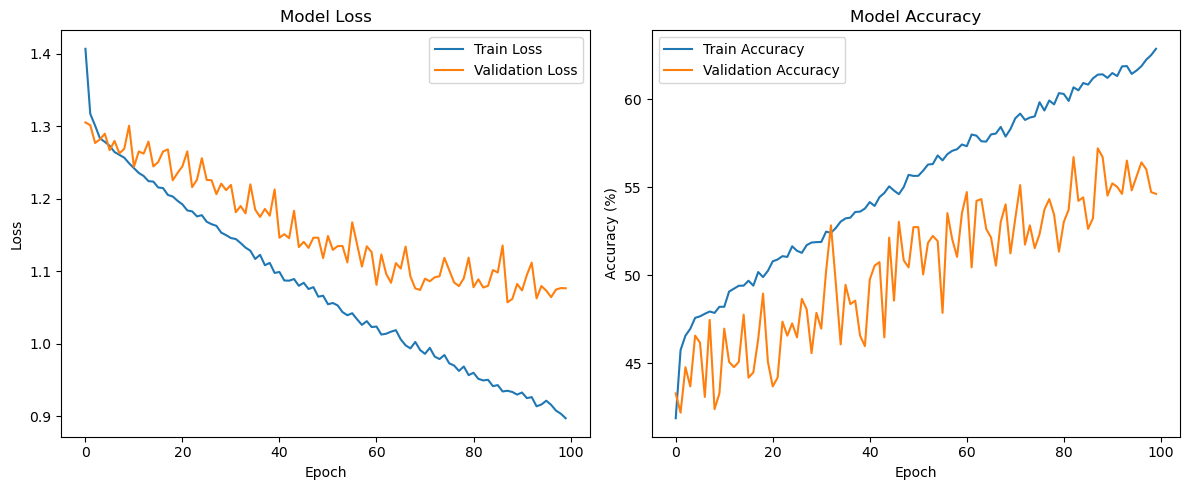

In [171]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_dim = X_train.shape[1]  # From your feature extraction
num_classes = 7  # Number of crystal structure classes
batch_size = 64
learning_rate = 0.001

# Create DataLoaders
train_dataset = XRDDataset(X_train, y_train)
val_dataset = XRDDataset(X_val, y_val)
test_dataset = XRDDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize model
model = XRDTransformer(
    input_dim=input_dim, 
    d_model=64,  # Transformer model dimension 
    nhead=4,     # Number of attention heads
    num_layers=2,# Number of transformer layers
    num_classes=num_classes
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Train the model
history = train_xrd_classifier(
    model, train_loader, val_loader, 
    criterion, optimizer, device, num_epochs=100, patience=20
)

# Plot training history
plot_training_history(history)

In [180]:
torch.save(model, "/Users/wasslu/Desktop/NTU/MLPhys/ML-course/xrdtrans_1.pt")

In [185]:
model_path = "/Users/wasslu/Desktop/NTU/MLPhys/ML-course/xrdtrans_1.pt"
loaded_model = torch.load(model_path)
print(loaded_model)

XRDTransformer(
  (input_projection): Sequential(
    (0): Linear(in_features=21, out_features=64, bias=True)
    (1): ReLU()
  )
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): 

/var/folders/dp/sx_sh4953xb0kh0760_6p1hh0000gn/T/ipykernel_83306/2643889922.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(model_path)


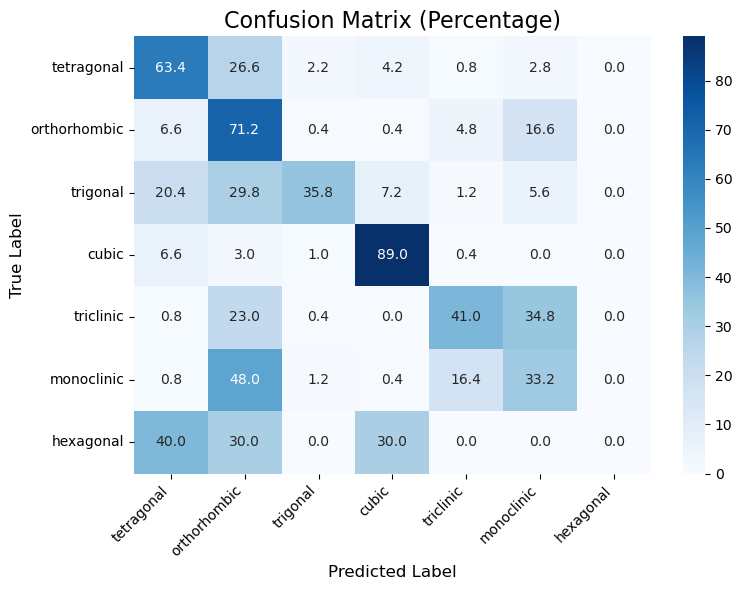

Classification Report:
               precision    recall  f1-score   support

  tetragonal       0.64      0.63      0.64       500
orthorhombic       0.35      0.71      0.47       500
    trigonal       0.87      0.36      0.51       500
       cubic       0.87      0.89      0.88       500
   triclinic       0.63      0.41      0.50       500
  monoclinic       0.36      0.33      0.34       500
   hexagonal       0.00      0.00      0.00        10

    accuracy                           0.55      3010
   macro avg       0.53      0.48      0.48      3010
weighted avg       0.62      0.55      0.55      3010



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


'              precision    recall  f1-score   support\n\n  tetragonal       0.64      0.63      0.64       500\northorhombic       0.35      0.71      0.47       500\n    trigonal       0.87      0.36      0.51       500\n       cubic       0.87      0.89      0.88       500\n   triclinic       0.63      0.41      0.50       500\n  monoclinic       0.36      0.33      0.34       500\n   hexagonal       0.00      0.00      0.00        10\n\n    accuracy                           0.55      3010\n   macro avg       0.53      0.48      0.48      3010\nweighted avg       0.62      0.55      0.55      3010\n'

In [183]:
evaluate_model(loaded_model, test_loader, device, label_names)